In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
dataframe = pd.read_csv('FocastIQ/test_files/PurchasesFINAL12312016.csv')

df = dataframe.copy()
df.head()


/Users/aousaf/Documents/Data_Science/DS_Tools_and_Technologies/Semester Project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
/var/folders/3m/b1vwyy8s3wsfsp00p40zl98h0000gn/T/ipykernel_1926/2104839684.py:10: DtypeWarning: Columns (0,3,4,6,8,9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('FocastIQ/test_files/PurchasesFINAL12312016.csv')


,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69.0,8412.0,Tequila Ocho Plata Fresno,750mL,105.0,ALTAMAR BRANDS LLC,8124.0,12/21/2015,1/2/2016,1/4/2016,2/16/2016,35.71,6.0,214.26,1.0
1,30_CULCHETH_5255,30.0,5255.0,TGI Fridays Ultimte Mudslide,1.75L,4466.0,AMERICAN VINTAGE BEVERAGE,8137.0,12/22/2015,1/1/2016,1/7/2016,2/21/2016,9.35,4.0,37.40,1.0
2,34_PITMERDEN_5215,34.0,5215.0,TGI Fridays Long Island Iced,1.75L,4466.0,AMERICAN VINTAGE BEVERAGE,8137.0,12/22/2015,1/2/2016,1/7/2016,2/21/2016,9.41,5.0,47.05,1.0
3,1_HARDERSFIELD_5255,1.0,5255.0,TGI Fridays Ultimte Mudslide,1.75L,4466.0,AMERICAN VINTAGE BEVERAGE,8137.0,12/22/2015,1/1/2016,1/7/2016,2/21/2016,9.35,6.0,56.10,1.0
4,76_DONCASTER_2034,76.0,2034.0,Glendalough Double Barrel,750mL,388.0,ATLANTIC IMPORTING COMPANY,8169.0,12/24/2015,1/2/2016,1/9/2016,2/16/2016,21.32,5.0,106.60,1.0


#### Better inventory planning: If the model knows that a certain tequila usually spikes before weekends or holidays, the buyer can place orders early and avoid stockouts that lose sales and annoy customers.​

#### Lower holding and wastage costs: Forecasting reduces over-ordering, which ties up cash and shelf space and risks product expiring or being discounted heavily.​

#### Smarter purchasing and cash-flow decisions: With a forward view of expected purchase quantities and spend (Quantity × PurchasePrice), management can negotiate with vendors, plan promotions, and schedule deliveries more efficiently.

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   InventoryId     999 non-null    object 
 1   Store           999 non-null    float64
 2   Brand           999 non-null    float64
 3   Description     999 non-null    object 
 4   Size            999 non-null    object 
 5   VendorNumber    999 non-null    float64
 6   VendorName      999 non-null    object 
 7   PONumber        999 non-null    float64
 8   PODate          999 non-null    object 
 9   ReceivingDate   999 non-null    object 
 10  InvoiceDate     999 non-null    object 
 11  PayDate         999 non-null    object 
 12  PurchasePrice   999 non-null    float64
 13  Quantity        999 non-null    float64
 14  Dollars         999 non-null    float64
 15  Classification  999 non-null    float64
dtypes: float64(8), object(8)
memory usage: 128.0+ MB


### Initial EDA

In [73]:
# Remove rows where all values are null
df = df.dropna(how='all')

# Fill remaining nulls with column means (numeric) and mode (categorical)
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])


In [74]:
columns = df.columns

if 'InventoryId' in columns:
    df = df.drop(columns=['InventoryId'])
df.head()
df.rename(columns={"Description": "Liquer"}, inplace=True)
print(f"Data: {columns}")

print(f"Total Unique Brands = {len(df['Liquer'].unique())}")


Data: Index(['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber',
       'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate',
       'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification'],
      dtype='object')
Total Unique Brands = 240


#### Resizing The bottle scale

In [75]:
def size_to_ml(size_str):
    size_str = str(size_str).lower().replace(' ', '')
    if 'ml' in size_str:
        # For formats like '750ml'
        number = size_str.replace('ml', '')
        try:
            return float(number)
        except:
            return None
    elif 'l' in size_str:
        number = size_str.replace('l', '')
        try:
            return float(number) * 1000
        except:
            return None
    else:
        return None

if 'Size' in df.columns:
    df['Size_ml'] = df['Size'].apply(size_to_ml)
    df = df.drop(columns=['Size'])
df.head()

,Store,Brand,Liquer,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification,Size_ml
0,69.0,8412.0,Tequila Ocho Plata Fresno,105.0,ALTAMAR BRANDS LLC,8124.0,12/21/2015,1/2/2016,1/4/2016,2/16/2016,35.71,6.0,214.26,1.0,750.0
1,30.0,5255.0,TGI Fridays Ultimte Mudslide,4466.0,AMERICAN VINTAGE BEVERAGE,8137.0,12/22/2015,1/1/2016,1/7/2016,2/21/2016,9.35,4.0,37.40,1.0,1750.0
2,34.0,5215.0,TGI Fridays Long Island Iced,4466.0,AMERICAN VINTAGE BEVERAGE,8137.0,12/22/2015,1/2/2016,1/7/2016,2/21/2016,9.41,5.0,47.05,1.0,1750.0
3,1.0,5255.0,TGI Fridays Ultimte Mudslide,4466.0,AMERICAN VINTAGE BEVERAGE,8137.0,12/22/2015,1/1/2016,1/7/2016,2/21/2016,9.35,6.0,56.10,1.0,1750.0
4,76.0,2034.0,Glendalough Double Barrel,388.0,ATLANTIC IMPORTING COMPANY,8169.0,12/24/2015,1/2/2016,1/9/2016,2/16/2016,21.32,5.0,106.60,1.0,750.0


In [127]:
def make_full_random_future(df_liquor: pd.DataFrame,
                            n_samples: int = 300,
                            months_ahead: int = 3) -> pd.DataFrame:
    df = df_liquor.copy()

    date_cols = ["PODate", "ReceivingDate", "InvoiceDate", "PayDate"]
    num_cols = ["Store", "Brand", "VendorNumber", "PONumber",
                "PurchasePrice", "Quantity", "Dollars", "Classification"]
    cat_cols = [c for c in df.columns if c not in date_cols + num_cols]

    # parse dates
    for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c])

    # stats for numeric cols
    num_stats = {}
    for c in num_cols:
        if c in df.columns:
            mean = df[c].mean()
            std = df[c].std(ddof=0)
            if np.isnan(std) or std == 0:
                std = abs(mean) * 0.1 if mean != 0 else 1.0
            num_stats[c] = (mean, std)

    last_dates = {c: df[c].max() for c in date_cols if c in df.columns}
    max_days = months_ahead * 30

    rows = []
    for _ in range(n_samples):
        row = {}

        # categorical columns: sample existing values
        for c in cat_cols:
            row[c] = df[c].sample(1).iloc[0]

        # numeric columns
        for c, (mean, std) in num_stats.items():
            val = np.random.normal(mean, std)
            if c in ["Store", "Brand", "VendorNumber", "PONumber",
                     "Quantity", "Classification"]:
                val = max(0, round(val))
            row[c] = float(val)

        # date columns
        for c, last_d in last_dates.items():
            offset = np.random.randint(1, max_days + 1)
            row[c] = last_d + pd.to_timedelta(offset, unit="D")

        rows.append(row)

    future_df = pd.DataFrame(rows)
    # ensure same column order as original
    future_df = future_df[df.columns]

    return future_df.sort_values("InvoiceDate").reset_index(drop=True)

#### Seperating each Liquer Data 

In [77]:
liquor_dfs:dict[str, pd.DataFrame] = {}

for brand in df['Liquer'].unique():
    liquor_dfs[brand] = df[df['Liquer'] == brand]

print(f"Liquers: \n {liquor_dfs.keys()}")


tequila = liquor_dfs['TGI Fridays Long Island Iced']

future_liquor_dfs: dict[str, pd.DataFrame] = {}

for liquor_name, df_liquor in liquor_dfs.items():
    if df_liquor.empty:
        print(f"Skipping {liquor_name} because df is empty")
        continue

    future_liquor_dfs[liquor_name] = make_full_random_future(
        df_liquor, n_samples=50, months_ahead=3
    )


Liquers: 
 dict_keys(['Tequila Ocho Plata Fresno', 'TGI Fridays Ultimte Mudslide', 'TGI Fridays Long Island Iced', 'Glendalough Double Barrel', 'Bombay Sapphire Gin', 'Bacardi 151 Proof', 'Bacardi Superior Rum', 'Grey Goose Le Citron Vodka', 'Castillo Silver Label Rum', "Grey Goose L'Orange Vodka", 'Dewars Special RSV 12-Yr', 'Bacardi Dragon Berry Rum', 'Grey Goose La Poire Vodka', 'Grey Goose Le Melon', 'Bombay Sapphire East Gin', 'M & R Sweet Vermouth', 'Bacardi Superior Rum Trav', 'Bacardi Limon Rum', 'Bombay Dry Gin', 'Dewars White Label', 'Grey Goose Vodka', 'Corzo Silver Tequila', 'Bacardi Gold Rum Traveler', 'Noilly Prat Extra Dry Vermou', 'Bacardi Gold Rum', 'Bacardi Black', 'Bacardi Party Mai Tai', 'Grey Goose Glass Pack', 'Bacardi Party Drinks Bahama', 'Grey Goose Cherry Noir Vodka', 'Bacardi Oakheart Spiced Rum', 'M & R Asti', 'M & R Extra Dry Vermouth', 'M & R X Dry Vermouth', 'Bacardi Black Razz', 'St Germain Liqueur', "D'Usse VSOP Cognac", 'Bacardi Tangerine Rum', 'M & R 

#### Removing Columns Dollars, Clasification

In [85]:
for liquer, data in future_liquor_dfs.items():
    if 'Dollars' in data.columns or 'Classification' in data.columns:
        future_liquor_dfs[liquer] = data.drop(columns=['Dollars', 'Classification'])

tequila = future_liquor_dfs['Tequila Ocho Plata Fresno']
tequila.head()

,Store,Brand,Liquer,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Size_ml
0,76.0,9456.0,Tequila Ocho Plata Fresno,105.0,ALTAMAR BRANDS LLC,7467.0,2016-01-21,2016-02-10,2016-01-08,2016-04-28,43.808652,6.0,750.0
1,65.0,8670.0,Tequila Ocho Plata Fresno,115.0,ALTAMAR BRANDS LLC,8469.0,2016-02-25,2016-02-10,2016-01-09,2016-04-22,32.970055,7.0,750.0
2,67.0,9693.0,Tequila Ocho Plata Fresno,103.0,ALTAMAR BRANDS LLC,8312.0,2016-03-20,2016-03-08,2016-01-09,2016-05-14,30.457075,6.0,750.0
3,61.0,8535.0,Tequila Ocho Plata Fresno,114.0,ALTAMAR BRANDS LLC,8514.0,2016-02-28,2016-02-24,2016-01-10,2016-03-26,36.080902,6.0,750.0
4,63.0,8268.0,Tequila Ocho Plata Fresno,97.0,ALTAMAR BRANDS LLC,8387.0,2016-03-14,2016-02-03,2016-01-12,2016-05-09,41.736157,7.0,750.0


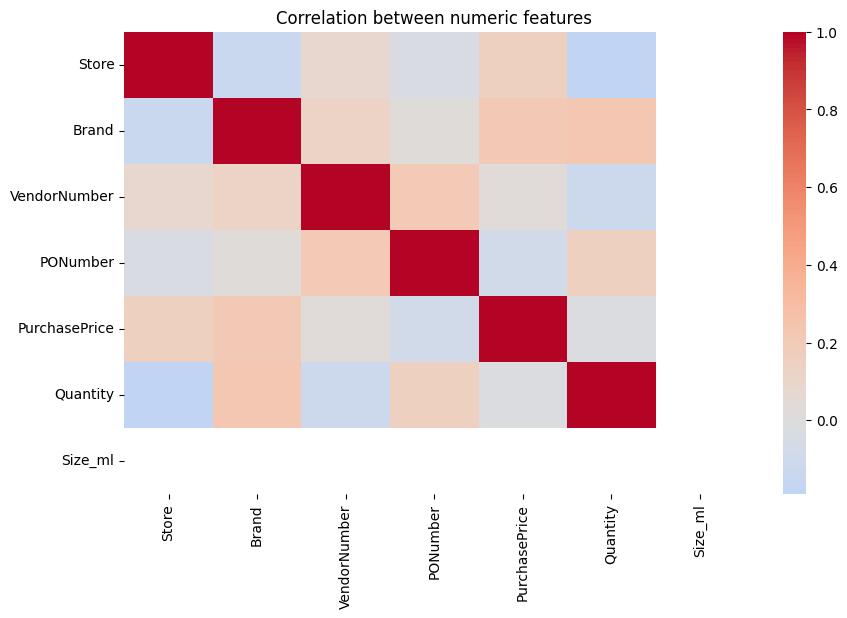

In [90]:
corr_with_qty = tequila.corr(numeric_only=True)["Quantity"].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr = tequila.corr(numeric_only=True)
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation between numeric features")
plt.show()

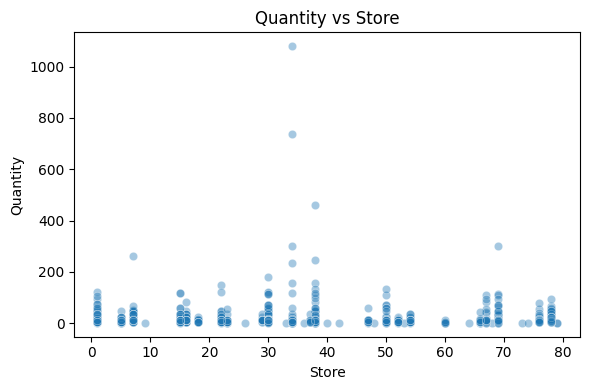

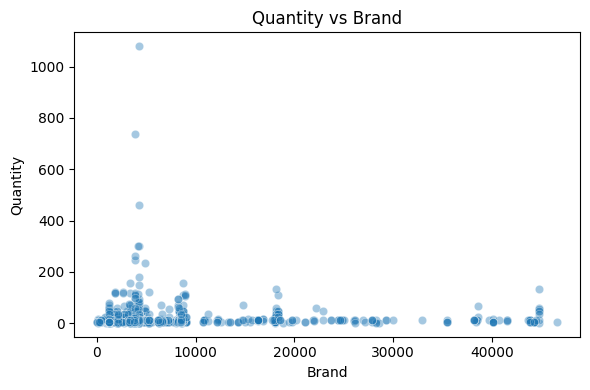

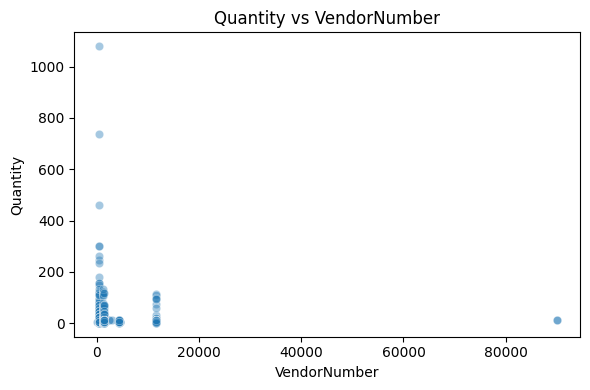

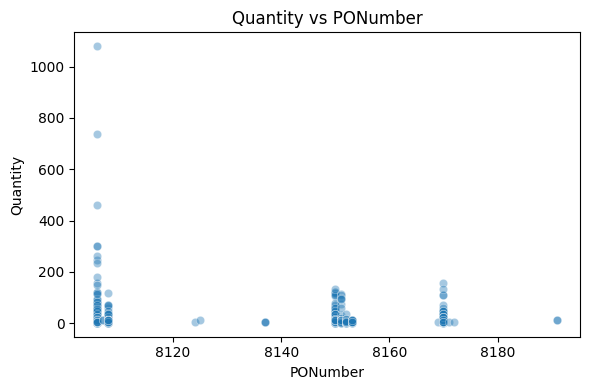

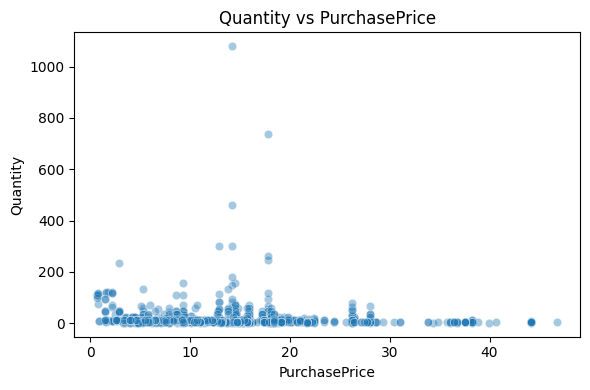

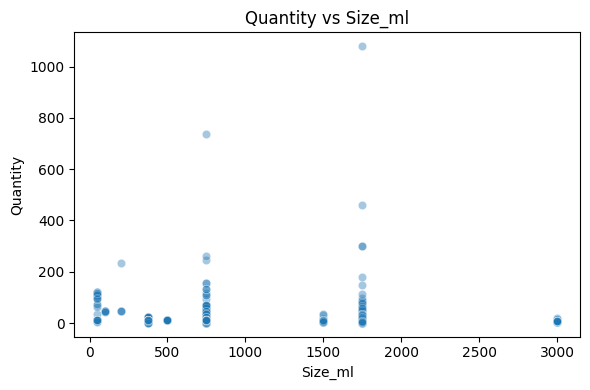

In [93]:

target = "Quantity"

# numeric and categorical columns
num_cols = tequila.select_dtypes(include=["number"]).columns.drop(target)
cat_cols = tequila.select_dtypes(exclude=["number"]).columns

# --- Scatter plots for numeric features ---
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=col, y=target, alpha=0.4)
    plt.title(f"{target} vs {col}")
    plt.tight_layout()
    plt.show()

# --- Boxplots for categorical features ---
# (limit levels to avoid overcrowded plots)
max_categories = 15


#### Store, Brand, VendorNumber, PONumber vs Quantity: points are scattered with no clear trend; quantities at many ID values are mostly low with a few spikes, which visually suggests low linear correlation.

In [97]:
cols_to_drop = [
    "Brand",
    "VendorNumber",
    "VendorName",
    "PODate",
    # add more here if you decide they are not useful
]
df_tequila_clear = tequila.drop(columns=cols_to_drop, errors="ignore").copy()
tequila["InvoiceDate"] = pd.to_datetime(tequila["InvoiceDate"])

# sort ascending (oldest to newest)
tequila_df_sorted = tequila.sort_values(by="InvoiceDate").reset_index(drop=True)

tequila_df_sorted.head()


,Store,Brand,Liquer,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Size_ml
0,76.0,9456.0,Tequila Ocho Plata Fresno,105.0,ALTAMAR BRANDS LLC,7467.0,2016-01-21,2016-02-10,2016-01-08,2016-04-28,43.808652,6.0,750.0
1,65.0,8670.0,Tequila Ocho Plata Fresno,115.0,ALTAMAR BRANDS LLC,8469.0,2016-02-25,2016-02-10,2016-01-09,2016-04-22,32.970055,7.0,750.0
2,67.0,9693.0,Tequila Ocho Plata Fresno,103.0,ALTAMAR BRANDS LLC,8312.0,2016-03-20,2016-03-08,2016-01-09,2016-05-14,30.457075,6.0,750.0
3,61.0,8535.0,Tequila Ocho Plata Fresno,114.0,ALTAMAR BRANDS LLC,8514.0,2016-02-28,2016-02-24,2016-01-10,2016-03-26,36.080902,6.0,750.0
4,63.0,8268.0,Tequila Ocho Plata Fresno,97.0,ALTAMAR BRANDS LLC,8387.0,2016-03-14,2016-02-03,2016-01-12,2016-05-09,41.736157,7.0,750.0


#### Normalize data

In [118]:
tequila_values = tequila["Quantity"].values.astype("float32").reshape(-1, 1)
tequila_scaler = MinMaxScaler(feature_range=(0, 1))
tequila_values_scaled = tequila_scaler.fit_transform(tequila_values)


In [120]:
def create_sequences(data, look_back=5):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 5
X, y = create_sequences(tequila_values_scaled, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))

# train / test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#### Training Model

In [121]:
model = Sequential([
    LSTM(32, input_shape=(look_back, 1)),
    Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30


/Users/aousaf/Documents/Data_Science/DS_Tools_and_Technologies/Semester Project/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.3083 - val_loss: 0.4439
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2689 - val_loss: 0.4049
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2324 - val_loss: 0.3685
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1986 - val_loss: 0.3348
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1691 - val_loss: 0.3039
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1405 - val_loss: 0.2764
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1173 - val_loss: 0.2523
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0968 - val_loss: 0.2326
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0826 - val_loss: 0.2185
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0737 - val_loss: 0.2101
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0688 - val_loss: 0.2062
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0678 - val_loss: 0.2051
Epoch 13/30

In [ ]:

# 2) Forecast function (same as before)
def forecast_next_n_days(model, last_values, scaler, n_days=30, look_back=5):
    # last_values: last `look_back` RAW quantities (not scaled)
    seq = scaler.transform(np.array(last_values).reshape(-1, 1))[:, 0]
    history = list(seq)
    preds_scaled = []

    for _ in range(n_days):
        x_input = np.array(history[-look_back:]).reshape((1, look_back, 1))
        yhat = model.predict(x_input, verbose=0)[0, 0]
        preds_scaled.append(yhat)
        history.append(yhat)

    preds = scaler.inverse_transform(
        np.array(preds_scaled).reshape(-1, 1)
    ).ravel()
    return preds

last_vals = tequila_values[-look_back:].ravel()
future_30_quantities = forecast_next_n_days(
    model, last_vals, tequila_scaler, n_days=30, look_back=look_back
)

last_date = tequila["InvoiceDate"].max()
future_dates = pd.date_range(last_date + pd.Timedelta(days=1),
                             periods=30, freq="D")

forecast_df = pd.DataFrame({
    "InvoiceDate": future_dates,
    "Predicted_Quantity": future_30_quantities
})


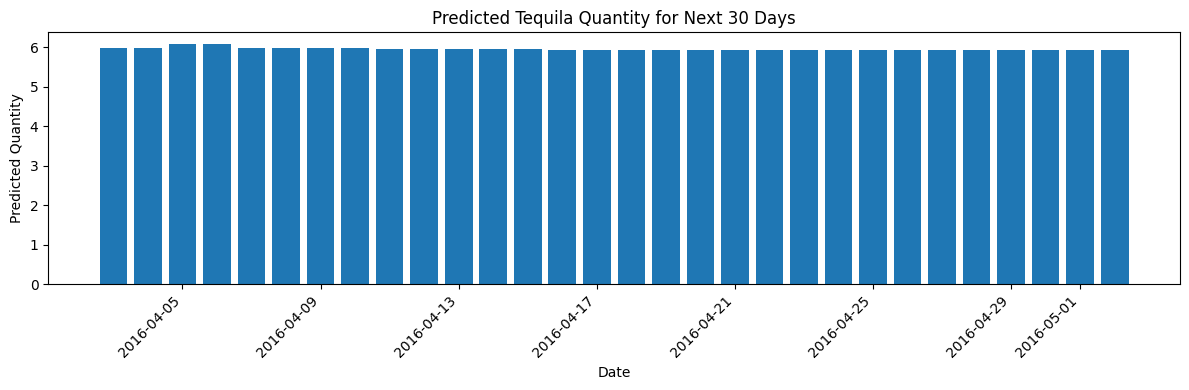

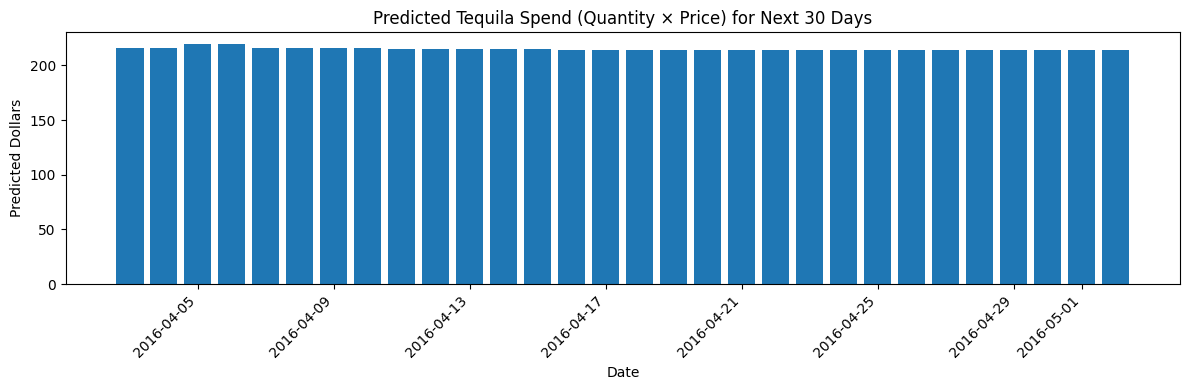

In [124]:

# 1) Compute a reference price (e.g., mean historical price)
avg_price = tequila["PurchasePrice"].mean()

# 2) Add predicted dollars column
forecast_df["Predicted_Dollars"] = forecast_df["Predicted_Quantity"] * avg_price

# 3) Bar plot: Quantity vs Date
plt.figure(figsize=(12, 4))
plt.bar(forecast_df["InvoiceDate"], forecast_df["Predicted_Quantity"])
plt.xticks(rotation=45, ha="right")
plt.title("Predicted Tequila Quantity for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Predicted Quantity")
plt.tight_layout()
plt.show()

# 4) Bar plot: Dollars vs Date
plt.figure(figsize=(12, 4))
plt.bar(forecast_df["InvoiceDate"], forecast_df["Predicted_Dollars"])
plt.xticks(rotation=45, ha="right")
plt.title("Predicted Tequila Spend (Quantity × Price) for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Predicted Dollars")
plt.tight_layout()
plt.show()

#### Comparison with Meta prophet library

12:23:22 - cmdstanpy - INFO - Chain [1] start processing
12:23:24 - cmdstanpy - INFO - Chain [1] done processing


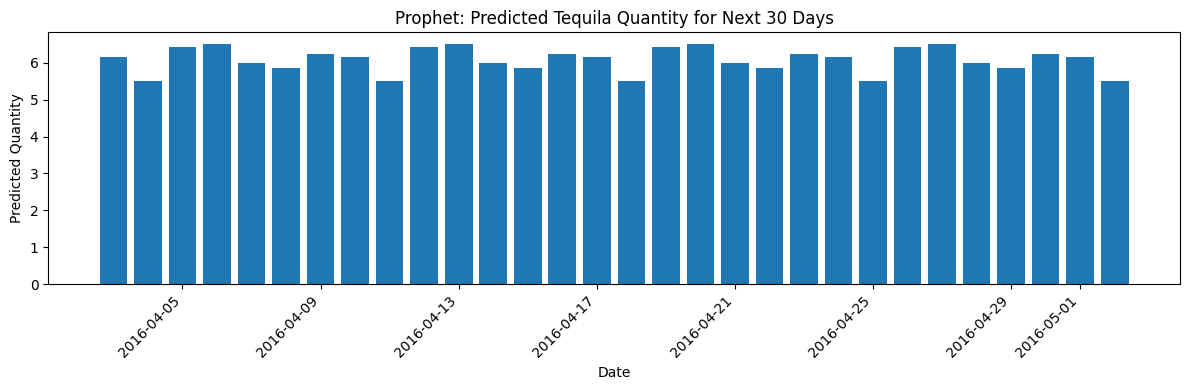

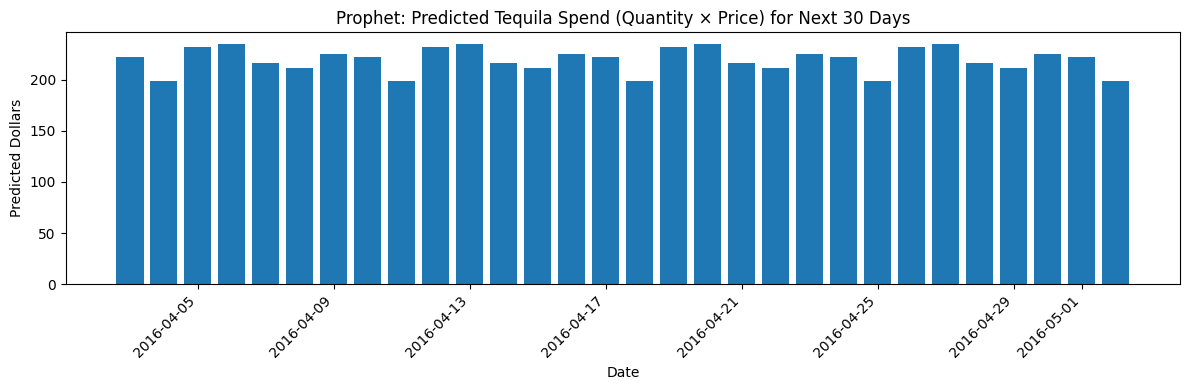

In [126]:
tequila_prophet = tequila[["InvoiceDate", "Quantity"]].copy()
tequila_prophet["InvoiceDate"] = pd.to_datetime(tequila_prophet["InvoiceDate"])
tequila_prophet = tequila_prophet.sort_values("InvoiceDate")

# Prophet expects columns: ds (date), y (value)
tequila_prophet = tequila_prophet.rename(columns={
    "InvoiceDate": "ds",
    "Quantity": "y"
})

# 2) Fit Prophet model
m = Prophet(daily_seasonality=True)
m.fit(tequila_prophet)

# 3) Make future dataframe for next 30 days
future = m.make_future_dataframe(periods=30, freq="D")
forecast = m.predict(future)

# keep only the future horizon
future_forecast = forecast[forecast["ds"] > tequila_prophet["ds"].max()][["ds", "yhat"]]
future_forecast = future_forecast.rename(columns={"ds": "InvoiceDate",
                                                  "yhat": "Predicted_Quantity"})

# 4) Compute Dollars = quantity * avg price
avg_price = tequila["PurchasePrice"].mean()
future_forecast["Predicted_Dollars"] = future_forecast["Predicted_Quantity"] * avg_price

# 5) Plot quantity vs date (bar)
plt.figure(figsize=(12, 4))
plt.bar(future_forecast["InvoiceDate"], future_forecast["Predicted_Quantity"])
plt.xticks(rotation=45, ha="right")
plt.title("Prophet: Predicted Tequila Quantity for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Predicted Quantity")
plt.tight_layout()
plt.show()

# 6) Plot dollars vs date (bar)
plt.figure(figsize=(12, 4))
plt.bar(future_forecast["InvoiceDate"], future_forecast["Predicted_Dollars"])
plt.xticks(rotation=45, ha="right")
plt.title("Prophet: Predicted Tequila Spend (Quantity × Price) for Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Predicted Dollars")
plt.tight_layout()
plt.show()